# Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Gaussian Mixture Density Network

In [3]:
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x=2, l=3, k=4, h=50,verbose=False):
        self.x = x  # no. of input features
        self.l = l  # no. of output features
        self.k = k  # no. of components
        self.h = h  # no. of units 
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        # Base layer
        input = tf.keras.Input(shape=(self.x,), name='input_layer')  # (None,2)
        layer = tf.keras.layers.Dense(50, activation='tanh', name='base_layer')(input)  # (None,50)

        # Kernel centres (K*L outputs)
        mu = tf.keras.layers.Dense(self.k * self.l, activation=None, name='mean_layer')(layer) # (None,6)

        # Kernel widths (K*L outputs)
        var_layer = tf.keras.layers.Dense(self.k * self.l, activation=None, name='dense_var_layer')(layer) # (None,6)
        var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(self.k * self.l,), name='variance_layer')(var_layer)  # (None,6)

        # Mixing coefficients (K outputs)
        pi = tf.keras.layers.Dense(self.k, activation='softmax', name='pi_layer')(layer)  # (None,3)

        # Model compilation
        self.model = tf.keras.models.Model(input, [pi, mu, var], name='model')
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        # Parameters of GMM
        k, l = self.k, self.l
        
        # Define GMM using TFP
        cat = tfd.Categorical(logits=pi)
        component_splits = [l] * k
        mu = tf.split(mu, num_or_size_splits=component_splits, axis=1)
        sigma = tf.split(sigma, num_or_size_splits=component_splits, axis=1)
        coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)  # TODO: Check diag
                for loc, scale in zip(mu, sigma)]
        return tfd.Mixture(cat=cat, components=coll)
        
    def loss(self, y_true, pi, mu, sigma):  # TODO: Use tfd log_prob
        """Negative log-likelihood."""
        mixture = self.tfdGMM(pi, mu, sigma)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        return tf.reduce_mean(loss)
    
    @tf.function
    def train_step(self, model, optimizer, train_x, train_y):
        """TF train function."""
        with tf.GradientTape() as tape:
            pi_, mu_, var_ = model(train_x, training=True)
            loss = self.loss(train_y, pi_, mu_, var_)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(self.model, self.optimizer, train_x, train_y)
                losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: Loss(NLL) {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training loss (NLL)')
            plt.show()
        
    def predict(self, X):
        return self.tfdGMM(*self.model.predict(X)).sample().numpy()
    
    def prob_plot(self, X_r, y_r, n_tiles=20, wrt_y=True, wrt_x=False):
        """Given a GMM and range of X and y, plot a surface plot."""
        
        # No. of features
        X_n, y_n = len(X_r), len(y_r)
        
        # Only handles up to 2D values
        if X_n > 2 or y_n > 2:
            return
        
        # Plot with respect to y
        if wrt_y:
            # 2D plot for y-axis
            if y_n == 2:
                X = np.linspace(X_r[0][0], X_r[0][1], n_tiles**2)  # TODO: Should fix an x particular value
                y_0 = np.linspace(y_r[0][0], y_r[0][1], n_tiles)
                y_1 = np.linspace(y_r[1][0], y_r[1][1], n_tiles)

                y0, y1 = np.meshgrid(y_0, y_1)
                y = np.stack((y0.flatten(), y1.flatten()), axis=1)
                y = np.squeeze(y)

                mix = self.get_gmm(X)
                prob = mix.prob(y).numpy().reshape((n_tiles, n_tiles))

                ax = plt.axes(projection='3d')
                plt.title("Probability with respect to y")
                ax.plot_surface(y0, y1, prob, cmap='viridis')
                plt.show()
            
            # 1D plot for y-axis
            elif y_n == 1:
                X_0 = np.linspace(X_r[0][0], X_r[0][1], n_tiles)
                X_1 = np.linspace(X_r[1][0], X_r[1][1], n_tiles)
                y = np.linspace(y_r[0][0], y_r[0][1], n_tiles)

                X = np.stack((X_0, X_1), axis=1)
                y = np.expand_dims(y, axis=1)

                mix = self.get_gmm(X)
                prob = mix.prob(y).numpy()

                plt.title("Probability with respect to y")
                plt.plot(y, prob)
                plt.show()
        
        # Plot with respect to X
        if wrt_x:
            # 2D plot for X-axis
            if X_n == 2:
                X_0 = np.linspace(X_r[0][0], X_r[0][1], n_tiles)  # TODO: Only X
                X_1 = np.linspace(X_r[1][0], X_r[1][1], n_tiles)
                y = np.linspace(y_r[0][0], y_r[0][1], n_tiles**2)
                y = np.expand_dims(y, axis=1)

                X0, X1 = np.meshgrid(X_0, X_1)
                X = np.stack((X0.flatten(), X1.flatten()), axis=1)
                X = np.squeeze(X)

                mix = self.get_gmm(X)
                prob = mix.prob(y).numpy().reshape((n_tiles, n_tiles))

                ax = plt.axes(projection='3d')
                plt.title("Probability with respect to X")
                ax.plot_surface(X0, X1, prob, cmap='viridis')
                plt.show()
            
            # 1D plot for X-axis
            if X_n == 1:
                X = np.linspace(X_r[0][0], X_r[0][1], n_tiles)
                y_0 = np.linspace(y_r[0][0], y_r[0][1], n_tiles)
                y_1 = np.linspace(y_r[1][0], y_r[1][1], n_tiles)

                X = np.expand_dims(X, axis=1)
                y = np.stack((y_0, y_1), axis=1)

                mix = self.get_gmm(X)
                prob = mix.prob(y).numpy()

                plt.title("Probability with respect to X")
                plt.plot(X, prob)
                plt.show()

# Datasets

In [4]:
def get_spiral_data(n=5000, plot=False):
    """Get spiral dataset of x=(n,1), y=(n,2)."""
    
    z_data = np.float32(np.random.uniform(-10.5, 10.5, n))
    r_data = np.random.normal(size=n)
    s_data = np.random.normal(size=n)
    x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
    y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0
    
    x_input = z_data.reshape((n, 1)).astype(np.float32)
    y_input = np.array([x_data,y_data]).T.astype(np.float32)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r')
        plt.show()
    
    return x_input, y_input

In [5]:
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

In [6]:
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()

X, y shapes: (4000, 2) (4000, 1)


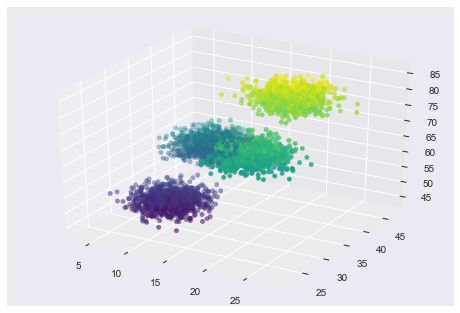

In [9]:
n = 1000

# # Use spiral dataset
# X, y = get_spiral_data(n)
# print(X.shape, y.shape)

# # Use wholesale dataset
# df = pd.read_csv("data/wholesale.csv")
# X = df[['Channel', 'Region']].values.astype(np.float32)
# y = df[['Fresh', 'Milk']].values.astype(np.float32)

# Use normal dataset
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(n)

# Model Training

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
base_layer (Dense)              (None, 50)           100         input_layer[0][0]                
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 8)            408         base_layer[0][0]                 
__________________________________________________________________________________________________
pi_layer (Dense)                (None, 4)            204         base_layer[0][0]                 
______________________________________________________________________________________________

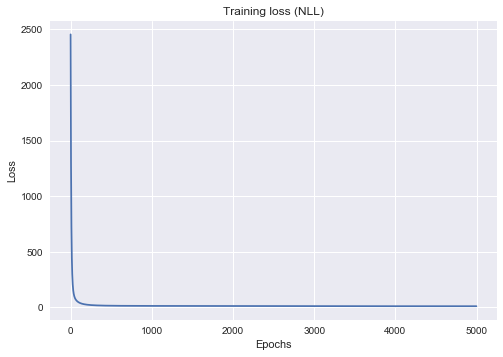

In [603]:
# Build GMM
gmm = GMM(x=1, l=2, k=4, h=10, verbose=True)
gmm.fit(dataset, epochs=5000, plot=True)
y_hat = gmm.predict(X)

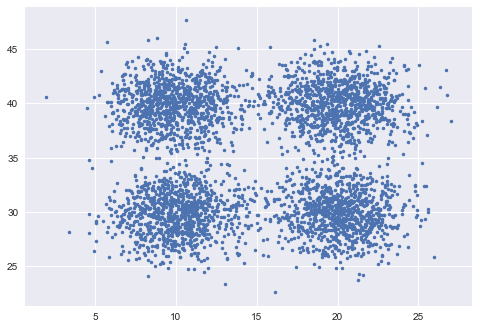

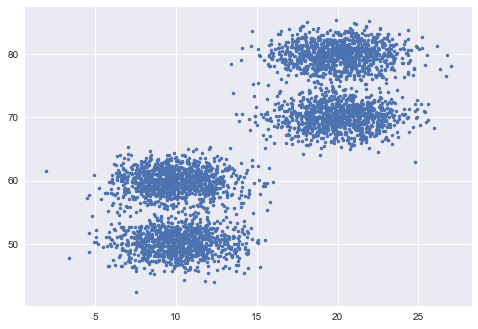

In [604]:
plot_data(X, y)

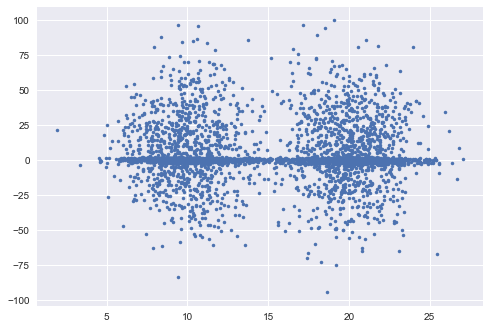

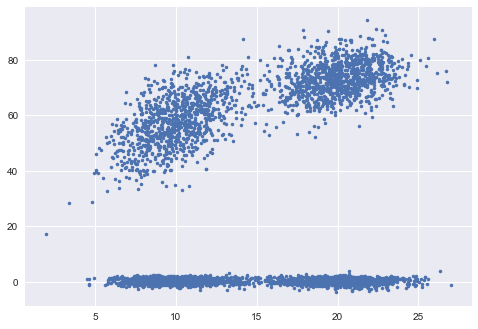

In [605]:
# Plot predicted data
plot_data(X, y_hat)

# Probability Density Visualisation

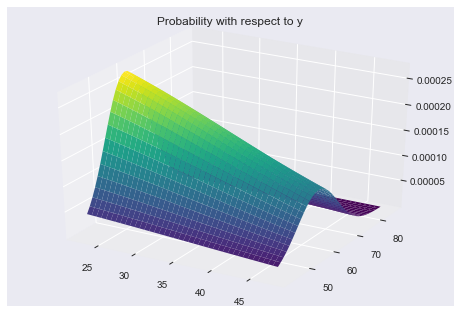

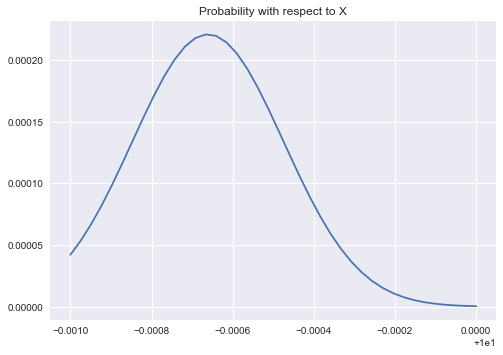

In [606]:
def get_min_max(X, adjust_min=0, adjust_max=0):
    """Get the min and max of X in [[min, max]] format."""
    Xrange = []
    for i in range(X.shape[1]):
        Xrange.append([min(X[:,i]) + adjust_min,
                       max(X[:,i]) + adjust_max])
    return Xrange

# Xrange = get_min_max(X)
yrange = get_min_max(y)
Xrange = [[9.999,10]]
# yrange = [[50,50], [70,70]]

gmm.prob_plot(Xrange, yrange, n_tiles=40, wrt_y=True, wrt_x=True)

# Distance Metrics

In [615]:
np.mean(gmm.get_gmm(X).log_prob(y).numpy())

-8.8625765

In [607]:
Xrange = get_min_max(X)
yrange = get_min_max(y)

In [608]:
x_test = np.linspace(Xrange[0][0], Xrange[0][1], 40)
y0 = np.linspace(yrange[0][0], yrange[0][1], 40)
y1 = np.linspace(yrange[1][0], yrange[1][1], 40)
y_test = np.stack((y0, y1), axis=1)

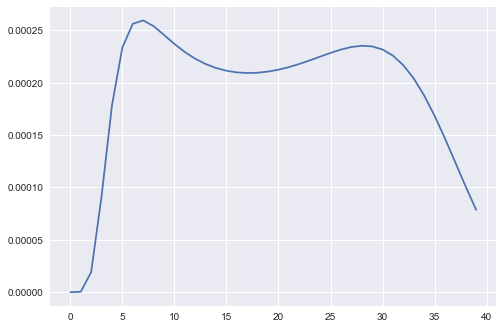

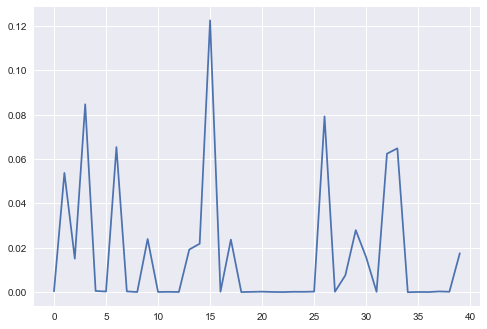

In [609]:
y_prob = gmm.get_gmm(x_test).prob(y_test).numpy()
plt.plot(y_prob)
plt.show()

y_pred = gmm.predict(x_test)
y_hat_prob = gmm.get_gmm(x_test).prob(y_pred).numpy()
plt.plot(y_hat_prob)
plt.show()

In [610]:
entropy(y_prob, y_hat_prob)

2.6924958